# Excluding "minorities" during training
What happens if an ML system is trained with data that exclude minorities, but it ends up being used extensively by a minority? A system trained on data that has historically excluded women (easy example: medical data) is very likely still being used by women as they make up basically half of the Earth's population.

In [39]:
from trecs.models import ContentFiltering, PopularityRecommender, SocialFiltering
from trecs.components import Users, PredictedUserProfiles
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from utils import create_profiles, calc_group_preferences
from custom_metrics import MajorityRecommendationShare, MajoritySharePopularItems
import matplotlib.pyplot as plt

## Training data
Look at a rec sys trained with data where Group A is the majority and Group B is the minority. Compositions can vary (in 5% intervals):
- Group A: 100%, Group B: 0%
- Group A: 95%, Group B: 5%
- Group A: 90%, Group B: 10%
- Group A: 85%, Group B: 15%
- ...
- Group A: 55%, Group B: 45%
- Group A: 50%, Group B: 50% (baseline)

## "Test" data
The system is then used by a balanced audience of users.
- Group A: 50%, Group B: 50%
- We could also look at a majority of Group B users.

In [9]:
# 1000 users, 10000 items
# We test with 800 group A, 200 group B
total_users = 1000
num_group_a = 800 # so group B has 200 users
num_attrs = 11

# 10000 items for Group A members
# 0 items for Group B members
total_items = 10000
num_items_a = 10000 # so group B created no item

train_user_profiles, item_profiles = create_profiles(
    total_users=total_users, 
    total_items=total_items, 
    dynamic_creators=False,
    num_majority_users=num_group_a, 
    num_majority_items=num_items_a, 
    group_strength=1, 
    num_attrs=num_attrs
)
# The following function call is meaningless here since we only have items from Group A
#calc_group_preferences(user_profiles, item_profiles, num_group_a, num_items_a)

Percentage of items generated by Group A: 1.0


In [30]:
p = PopularityRecommender(
    actual_item_representation=item_profiles, 
    actual_user_representation=Users(
        actual_user_profiles=train_user_profiles, 
        num_users=total_users
    )
)
p.add_metrics(MajorityRecommendationShare(9), MajoritySharePopularItems(total_items, 9))
# Train with majority group
p.startup_and_train(timesteps=100)

100%|██████████| 100/100 [00:05<00:00, 18.39it/s]


In [36]:
# Switch users to balanced maj/min group
num_group_a_test = 500

test_user_profiles, _ = create_profiles(
    total_users=total_users, 
    total_items=total_items, 
    dynamic_creators=False,
    num_majority_users=num_group_a_test, 
    num_majority_items=num_items_a, 
    group_strength=0.6, 
    num_attrs=num_attrs
)
test_users = Users(actual_user_profiles=test_user_profiles, num_users=total_users)
test_users.compute_user_scores(item_attributes=p.items)

Percentage of items generated by Group A: 1.0


In [37]:
p.users = test_users
p.run(timesteps=100, train_between_steps=False)

100%|██████████| 100/100 [00:54<00:00,  1.84it/s]


Now we plot the dominance of the majority group's items. Because there are only items generated for the majority group, it makes sense that throughout the whole simulation 100% of the items are for the majority group.

Text(0, 0.5, 'Majority Group Dominance of Recommendations')

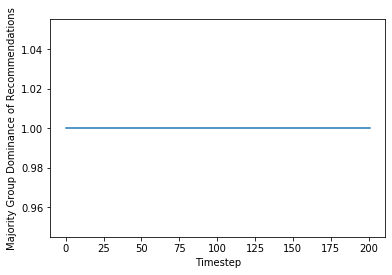

In [40]:
plt.plot(p.get_measurements()['majority_dominance'][1:])
plt.xlabel("Timestep")
plt.ylabel("Majority Group Dominance of Recommendations")

It's more interesting to look at metrics of utility